In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms as T, io

import torchutils as tu


In [ ]:
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'sports-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209061%2F5595172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240329%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240329T071544Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D50b508b9ec5a62847b36cf8f3fed23007e60945e64b7cd793ddcb6285a5809b255feb12e36d2a63d0b044df72bebbe242dbf027a5310203b3f487f7b0f6a993b17c725972fa563902a9166900ad9250e4a0935abb1421b2849e03f86362a3d64b3606177938905579e42ff20fc8c2e53d058b611c4da6a42a89fb1914817dd09f185ddf66107a2c7a6943f94c41307d9dce31f32f26bbbf703ff3db8e6c7057d0705ddefb886234cf64720cc7421e78cf028c3169c9b18f5eff368f69cbacbf473bdd5cefcbc8fbc1f6ea1d1209bce3cf17f3a239d617f857a22151ac67622550495c122bf96d13db8d945427c1699846bf7cf87c57c923eedd06d7095408085'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 444540604 bytes downloaded
Downloaded and uncompressed: sports-classification
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Выходные данные были обрезаны до нескольких последних строк (5000).
/kaggle/input/sports-classification/train/polo/007.jpg
/kaggle/input/sports-classification/train/polo/147.jpg
/kaggle/input/sports-classification/train/polo/011.jpg
/kaggle/input/sports-classification/train/polo/100.jpg
/kaggle/input/sports-classification/train/polo/019.jpg
/kaggle/input/sports-classification/train/polo/134.jpg
/kaggle/input/sports-classification/train/polo/070.jpg
/kaggle/input/sports-classification/train/polo/048.jpg
/kaggle/input/sports-classification/train/polo/152.jpg
/kaggle/input/sports-classification/train/polo/059.jpg
/kaggle/input/sports-classification/train/polo/050.jpg
/kaggle/input/sports-classification/train/polo/104.jpg
/kaggle/input/sports-classification/train/polo/041.jpg
/kaggle/input/sports-classification/train/polo/021.jpg
/kaggle/input/sports-classification/train/polo/144.jpg
/kaggle/input/sports-classification/train/polo/004.jpg
/kaggle/input/sports-classification/train/polo/022.j

In [ ]:
data_path = "/kaggle/input/sports-classification/train"
sport_folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
sport_folder_labels = {}

for index, sport_folder in enumerate(sport_folders):
    sport_folder_labels[sport_folder] = index

print(sport_folder_labels)

{'log rolling': 0, 'baton twirling': 1, 'ampute football': 2, 'figure skating pairs': 3, 'parallel bar': 4, 'trapeze': 5, 'speed skating': 6, 'horse jumping': 7, 'bobsled': 8, 'cheerleading': 9, 'canoe slamon': 10, 'weightlifting': 11, 'pommel horse': 12, 'shot put': 13, 'frisbee': 14, 'figure skating women': 15, 'air hockey': 16, 'fencing': 17, 'billiards': 18, 'sailboat racing': 19, 'axe throwing': 20, 'hockey': 21, 'barell racing': 22, 'sidecar racing': 23, 'bmx': 24, 'swimming': 25, 'pole dancing': 26, 'luge': 27, 'snow boarding': 28, 'rugby': 29, 'balance beam': 30, 'field hockey': 31, 'ski jumping': 32, 'figure skating men': 33, 'bowling': 34, 'rings': 35, 'curling': 36, 'snowmobile racing': 37, 'steer wrestling': 38, 'football': 39, 'hydroplane racing': 40, 'skydiving': 41, 'pole climbing': 42, 'rollerblade racing': 43, 'table tennis': 44, 'horse racing': 45, 'basketball': 46, 'mushing': 47, 'cricket': 48, 'chuckwagon racing': 49, 'judo': 50, 'sumo wrestling': 51, 'jousting': 52

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [ ]:
trnsfrms_for_train = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)
trnsfrms_for_valid = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)

In [ ]:
import torchvision
train_dataset = torchvision.datasets.ImageFolder('/kaggle/input/sports-classification/train',
                                                 transform=trnsfrms_for_train)
valid_dataset = torchvision.datasets.ImageFolder('/kaggle/input/sports-classification/valid',
                                                 transform=trnsfrms_for_valid)

In [ ]:
idx2class = {j: i for i, j in train_dataset.class_to_idx.items()}
idx2class

{0: 'air hockey',
 1: 'ampute football',
 2: 'archery',
 3: 'arm wrestling',
 4: 'axe throwing',
 5: 'balance beam',
 6: 'barell racing',
 7: 'baseball',
 8: 'basketball',
 9: 'baton twirling',
 10: 'bike polo',
 11: 'billiards',
 12: 'bmx',
 13: 'bobsled',
 14: 'bowling',
 15: 'boxing',
 16: 'bull riding',
 17: 'bungee jumping',
 18: 'canoe slamon',
 19: 'cheerleading',
 20: 'chuckwagon racing',
 21: 'cricket',
 22: 'croquet',
 23: 'curling',
 24: 'disc golf',
 25: 'fencing',
 26: 'field hockey',
 27: 'figure skating men',
 28: 'figure skating pairs',
 29: 'figure skating women',
 30: 'fly fishing',
 31: 'football',
 32: 'formula 1 racing',
 33: 'frisbee',
 34: 'gaga',
 35: 'giant slalom',
 36: 'golf',
 37: 'hammer throw',
 38: 'hang gliding',
 39: 'harness racing',
 40: 'high jump',
 41: 'hockey',
 42: 'horse jumping',
 43: 'horse racing',
 44: 'horseshoe pitching',
 45: 'hurdles',
 46: 'hydroplane racing',
 47: 'ice climbing',
 48: 'ice yachting',
 49: 'jai alai',
 50: 'javelin',
 5

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=92, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=92, shuffle=True)

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
class MyResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
    #замена слоя
    self.model.fc = nn.Linear(512, 100)
    #разморозка
    for i in self.model.parameters():
      i.requires_grad = False

    self.model.fc.weight.requires_grad = True
    self.model.fc.bias.requires_grad = True

  def forward(self, x):
    return self.model(x)

model = MyResNet()
model.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


MyResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
tu.get_model_summary(model, torch.randn(130, 3, 224, 224, device=DEVICE))

Layer                                             Kernel              Output           Params              FLOPs
0_model.Conv2d_conv1                            [3, 64, 7, 7]   [130, 64, 112, 112]       9,408   15,341,813,760
1_model.BatchNorm2d_bn1                                  [64]   [130, 64, 112, 112]         128      417,464,320
2_model.ReLU_relu                                           -   [130, 64, 112, 112]           0                0
3_model.MaxPool2d_maxpool                                   -     [130, 64, 56, 56]           0                0
4_model.layer1.0.Conv2d_conv1                  [64, 64, 3, 3]     [130, 64, 56, 56]      36,864   15,028,715,520
5_model.layer1.0.BatchNorm2d_bn1                         [64]     [130, 64, 56, 56]         128      104,366,080
6_model.layer1.0.ReLU_relu                                  -     [130, 64, 56, 56]           0                0
7_model.layer1.0.Conv2d_conv2                  [64, 64, 3, 3]     [130, 64, 56, 56]      36,864 

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.5 MB/s eta 0:00:00


In [ ]:
from torcheval.metrics.functional import multiclass_f1_score
import time

train_epoch_acc = []
train_epoch_f1 = []
train_epoch_losses = []

valid_epoch_acc = []
valid_epoch_f1 = []
valid_epoch_losses = []

start_time = time.time()

for epoch in range(8):
  model.train()
  loss_batch = []
  acc_batch = []
  f1_batch = []

  for images, labels in train_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    preds = model(images).squeeze(-1)
    loss = criterion(preds, labels)
    loss_batch.append(loss.item())

    accuracy = (preds.sigmoid().argmax(dim=1) == labels).cpu().numpy().mean()
    acc_batch.append(accuracy)

    f1 = multiclass_f1_score(preds.sigmoid().argmax(dim=1), labels, num_classes=100).cpu().numpy().mean()
    f1_batch.append(f1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_epoch_f1.append(np.mean(f1_batch))
  train_epoch_losses.append(np.mean(loss_batch))
  train_epoch_acc.append(np.mean(acc_batch))

  model.eval()
  loss_batch = []
  acc_batch = []
  f1_batch = []

  for images, labels in valid_loader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    preds = model(images).squeeze(-1)

    loss = criterion(preds, labels)
    loss_batch.append(loss.item())

    accuracy = (preds.sigmoid().argmax(dim=1) == labels).cpu().numpy().mean()
    acc_batch.append(accuracy)

    f1 = multiclass_f1_score(preds.sigmoid().argmax(dim=1), labels, num_classes=100).cpu().numpy().mean()
    f1_batch.append(f1)

  valid_epoch_f1.append(np.mean(f1))
  valid_epoch_losses.append(np.mean(loss_batch))
  valid_epoch_acc.append(np.mean(acc_batch))
  print(f"Epoch: {epoch} loss_train: {train_epoch_losses[-1]:.3f}, loss_valid: {valid_epoch_losses[-1]:.3f}")
  print(f"\t accuracy_train: {train_epoch_acc[-1]:.3f}, accuracy_valid: {valid_epoch_acc[-1]:.3f}")
  print(f"\t f1_train: {train_epoch_f1[-1]:.3f}, f1_valid: {valid_epoch_f1[-1]:.3f}")

end_time = time.time()  # Зафиксируем время окончания обучения
training_time = end_time - start_time  # Вычислим общее время обучения модели

print(f"Общее время обучения модели: {training_time} секунд")

Epoch: 0 loss_train: 2.739, loss_valid: 1.453
	 accuracy_train: 0.471, accuracy_valid: 0.725
	 f1_train: 0.471, f1_valid: 0.675
Epoch: 1 loss_train: 1.168, loss_valid: 0.887
	 accuracy_train: 0.791, accuracy_valid: 0.808
	 f1_train: 0.791, f1_valid: 0.675
Epoch: 2 loss_train: 0.800, loss_valid: 0.651
	 accuracy_train: 0.842, accuracy_valid: 0.852
	 f1_train: 0.842, f1_valid: 0.875
Epoch: 3 loss_train: 0.630, loss_valid: 0.602
	 accuracy_train: 0.874, accuracy_valid: 0.848
	 f1_train: 0.874, f1_valid: 0.775
Epoch: 4 loss_train: 0.527, loss_valid: 0.512
	 accuracy_train: 0.890, accuracy_valid: 0.888
	 f1_train: 0.890, f1_valid: 0.925
Epoch: 5 loss_train: 0.454, loss_valid: 0.457
	 accuracy_train: 0.905, accuracy_valid: 0.882
	 f1_train: 0.905, f1_valid: 0.925
Epoch: 6 loss_train: 0.396, loss_valid: 0.444
	 accuracy_train: 0.919, accuracy_valid: 0.889
	 f1_train: 0.919, f1_valid: 0.875
Epoch: 7 loss_train: 0.359, loss_valid: 0.419
	 accuracy_train: 0.927, accuracy_valid: 0.891
	 f1_train:

In [ ]:
torch.save(model, 'model_18.pt')

In [ ]:
resize = T.Resize((244, 244))

In [ ]:
!wget -o image8.jpeg https://www.mevis-piter.ru/wp-content/uploads/2017/05/DTE0KpekXb-e1498219870203.jpg

85


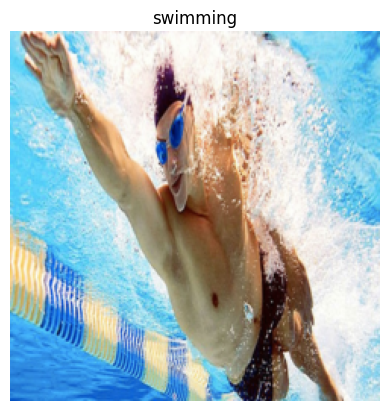

In [ ]:
img3 = resize(io.read_image('/content/DTE0KpekXb-e1498219870203.jpg')/255)
model.to(DEVICE)
plt.imshow(torch.permute(img3, (1, 2, 0)))
with torch.inference_mode():
  pred_class = model(img3.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()
(print(pred_class))
plt.axis('off')
plt.title(idx2class[pred_class]);

In [ ]:
!wget -o image2.jpeg https://smartgambling.ru/storage/app/media/uploaded-files/125916.jpg

41


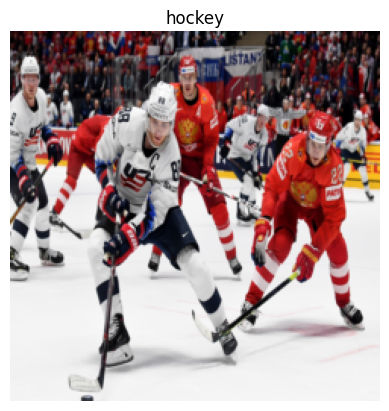

In [ ]:
img3 = resize(io.read_image('/content/125916.jpg')/255)
model.to(DEVICE)
plt.imshow(torch.permute(img3, (1, 2, 0)))
with torch.inference_mode():
  pred_class = model(img3.unsqueeze(0).to(DEVICE)).argmax(dim=1).item()
(print(pred_class))
plt.axis('off')
plt.title(idx2class[pred_class]);